<a href="https://colab.research.google.com/github/jeffrey96158/108062219_project3/blob/master/Vertical_Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package

In [1]:
# pytorch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.datasets as dset 
import torchvision.transforms as transforms
import torch.utils.data as data

# others
from tqdm.notebook import tqdm as tqdm
import argparse
from sklearn.metrics import f1_score
import random

import matplotlib.pyplot as plt
import numpy as np

# Download Dataset (MNIST)
MNIST is a data set of handwrite number

In [2]:
trans = transforms.Compose([transforms.ToTensor()]) 
train_set = dset.MNIST(root='.', train=True, download=True ,transform=trans)
test_set = dset.MNIST(root='.', train=False,transform=trans)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Arguments

In [3]:
parser = argparse.ArgumentParser(description='FL with PyTorch MNIST')
parser.add_argument('--no-cuda', action='store_true', default=False, 
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=50, metavar='S',
                    help='random seed (default: 50)')
parser.add_argument('--epochs', type=int, default=1, metavar='N',
                    help='number of epochs to train (default: 1)')
parser.add_argument('--lr', type=float, default=0.1, metavar='LR',
                    help='learning rate (default: 0.1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--batch-size', type=int, default=50, metavar='N',
                    help='input batch size for training (default: 50)')
parser.add_argument('--test-batch-size', type=int, default=50, metavar='N',
                    help='input batch size for testing (default: 50)')
parser.add_argument('--num-participants', type=int, default=10, metavar='NP',
                    help='number of participants (default: 10)')
parser.add_argument('--randomorder_rounds', type=int, default=1, metavar='NP',
                    help='rounds for Random Order (default: 1)')
parser.add_argument('--asynchronous_rounds', type=int, default=1, metavar='NP',
                    help='rounds for Asynchronous (default: 1)')
args = parser.parse_args(args=[])

# Class Definition

In [4]:
## Initialization
# Control Seed
# CUDA is a GPU core for parrallel computing
torch.manual_seed(args.seed)

# Select Device
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else 'cpu')

if use_cuda:
    print("Using CUDA!")
    torch.cuda.manual_seed(args.seed)
else:
    print('Not using CUDA!!!')

Using CUDA!


# Network
- Split the network into client_network and server_network
- client_network and server_network get half of the module.

In [5]:
#使用linear regression model
#連續使用3次linear regression
class network(nn.Module):
    def __init__(self):
        super(network,self).__init__()
        self.L1 = nn.Linear(784,128)
        self.L2 = nn.Linear(128,64)
        self.output = nn.Linear(64,10)
    def forward(self , x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = self.output(x)  #若是loss用crossentropy 他最後一層會自己用softmax
        return x
        
class client_network(nn.Module):
    def __init__(self):
        super(client_network,self).__init__()
        self.L1 = nn.Linear(784,128)
        self.L2 = nn.Linear(128,64)
    def forward(self , x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        return x

class server_network(nn.Module):
    def __init__(self, num):
        super(server_network,self).__init__()
        self.output = nn.Linear(64*num,10)
    def forward(self, x):
        x = self.output(x)  #若是loss用crossentropy 他最後一層會自己用softmax
        return x

#Client

In [6]:
class Participant():
    def __init__(self):
        global device
        self.local_network = client_network().to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        self.lr = args.lr
        self.optimizer = torch.optim.SGD(params=self.local_network.parameters(torch.tensor(1.0, requires_grad=True)), lr = self.lr)
        self.loss_history = []
        self.testloss_history = []
        self.accu_history = []
        self.gradient_buffer = dict() # download grandient_buffer
    def Upload(self, net_out, GlobalServer):
        GlobalServer.ServerFP(net_out)
    
    def Download(self, GlobalServer):# Download parameters from server
        self.local_network.load_state_dict(GlobalServer.global_network.state_dict()) 
    
    def LocalTraining(self, train_dataset, GlobalServer, epochs = 1, DownUp_cmd = "DU"):
        for e in range(epochs):
            epoch_loss_sum = 0
            pbar = tqdm(enumerate(train_dataset), total=len(train_dataset))
            for batch_idx, (data, label) in pbar:
                # same as HFL
                data, label = data.to(device), label.to(device)
                batch_size = data.shape[0]
                data = data.view(batch_size,-1) # 把data tensor的shape做改變
                net_out = self.local_network(data) # 把x丟進net去train，得到output
                # from here, upload the parameter to server.
                self.Upload(net_out, GlobalServer) # upload {netout} to {server}.
                # global server will calculate the gradient.
                self.Download(GlobalServer) # Download {gradient} from {server} (store in gradient_buffer)
                self.AddGradient() # there's no Participant().AddGradient()
                # same as HFL
                if (batch_idx+1) % args.log_interval == 0:
                    done = (batch_idx+1) * len(data)
                    percentage = 100. * (batch_idx+1) / len(train_dataset)
                    pbar.set_description(f'Train Epoch: {e} [{done:5}/{len(train_dataset.dataset)} ({percentage:3.0f}%)]')
    def LocalTrain(self,data):
      net_out = self.local_network(data)
      return net_out
    def LocalTesting(self, test_dataset):# same as HFL
        self.local_network.eval()
        correct = 0
        epoch_loss_sum = 0
        Labels = []
        Predicts = []
        with torch.no_grad():
            for data, label in test_dataset:
                data, label = data.to(device), label.to(device)
                batchsize = data.shape[0]
                data = data.view(batchsize, -1)
                net_out = self.local_network(data)
                loss = self.loss_fn(net_out, label)
                epoch_loss_sum += float(loss.item())

                predict = net_out.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
                correct += predict.eq(label.data.view_as(predict)).sum().item()
                Labels = Labels + label.tolist()
                Predicts = Predicts + predict.tolist()

            epoch_loss_sum /= len(test_dataset.dataset)
            accuracy = 100. * correct / len(test_dataset.dataset)
            self.testloss_history.append(epoch_loss_sum)
            self.accu_history.append(accuracy / 100)
            f1 = f1_score(Labels, Predicts, average = "macro")
            print(f'Test set: Average loss: {epoch_loss_sum:.4f}, Accuracy: {correct}/{len(test_dataset.dataset)} ({accuracy:.2f}%), F1-score: {f1:.4f}')



#Server

In [7]:
class GlobalServer():
    def __init__(self,num):
        global device
        self.global_network = server_network(num).to(device)
        self.gradient_buffer = dict()
        self.temp_gradient_buffer = dict()
        self.loss_history = []
        self.lr = args.lr
        self.optimizer = torch.optim.SGD(params=self.global_network.parameters(torch.tensor(1.0, requires_grad=True)), lr = self.lr)
        self.loss_fn = nn.CrossEntropyLoss()
        # GlobalServer set a dict to preserve net_out
        self.net_out_buffer = dict()
        self.label_buffer = dict()
    def AddGradient(self):
        state_dict_tmp = self.global_network.state_dict()
        for key in state_dict_tmp.keys():
            state_dict_tmp[key] += self.gradient_buffer[key]
        self.temp_gradient_buffer = self.gradient_buffer.copy()
        self.global_network.load_state_dict(state_dict_tmp)
        self.gradient_buffer.clear()
    def Append_loss(self, loss_sum):
        self.loss_history.append(loss_sum)

    def ServerFP(self, net_out):
        label = label.to(device)
        server_out = self.global_network(net_out)
        loss = self.loss_fn(net_out,label)
        self.optimizer.zero_grad() # clear gradient
        loss.backward() # back propagation
        #opt.step() # parameter update
        # for layer, param in zip(ln.state_dict().keys(), ln.parameters()):
        #   if (self.gradient_buffer.get(layer) == None): 
        #     self.gradient_buffer[layer] = -1 * param.grad * self.lr
        #   else:
        #     self.gradient_buffer[layer] -= param.grad * self.lr
        self.AddGradient();
    def ServerTrain(self,net_in):
      net_out = self.global_network(net_in)
      return net_out

#SplitData

In [8]:
def GenerateParticipant(num = 1):
    P_dict = dict()
    for i in range(num):
        s = 'P'
        s = s + str(i)
        P_dict[s] = Participant()

    return P_dict

# TrainSet_list[num], TestSet_list[num] -> store the name
# TrainDataSet_dict[num], TestDataSet_dict[num] -> store the data
def SplitData(train_set, test_set, num):
    if len(train_set) % num or len(test_set) % num:
        print(f"len(train_set):{len(train_set)}, len(test_set):{len(test_set)}, can not be indivisible by {num}")
        return
    
    train_split = int(len(train_set) / num)
    test_split = int(len(test_set) / num)

    portions = [train_split] * num
    TrainSet_list = [None] * num
    TrainSet_list = data.random_split(train_set, portions)

    portions = [test_split] * num
    TestSet_list = [None] * num
    TestSet_list = data.random_split(test_set, portions)

    TrainDataSet_dict = dict()
    TestDataSet_dict = dict()

    # mini batch
    for i in range(num):
        s = 'P'
        s = s + str(i)
        TrainDataSet_dict[s] = data.DataLoader(dataset =  TrainSet_list[i], batch_size=args.batch_size, shuffle=True, num_workers = 0)
        TestDataSet_dict[s] = data.DataLoader(dataset =  TestSet_list[i], batch_size=args.test_batch_size, shuffle=True, num_workers = 0)

    return TrainDataSet_dict, TestDataSet_dict

# Training

In [9]:
def vertical_train(train_dataset, Client, Server, epochs =  1):
  for e in range(epochs):
    epoch_loss_sum = 0
    pbar = tqdm(enumerate(train_dataset), total= len(train_dataset))
    for batch_idx, (data, label) in pbar:
      data, label = data.to(device), label.to(device)
      batch_size = data.shape[0]
      data = data.view(batch_size,-1) # 把data tensor的shape做改變
      # Step2: Bottom model forward propagation. 
      # each client using local data complete a foward propagation 
      client_out = Client.LocalTrain(data) #使用client進行model train
      # Step3: Forward output transmission
      # transmit forward output to server. May divulge privacy information
      # Step4: Top model forward propagation.
      server_out = Server.ServerTrain(client_out) #使用client output 給server model train
      print(label)
      server_loss = Server.loss_fn(server_out, label)
      client_loss = Server.loss_fn(client_out, label)
      # Step 5: Server backward
      Server.optimizer.zero_grad()
      server_loss.backward(retain_graph=True)
      Server.optimizer.step()
      # Step 7: Client backward
      Client.optimizer.zero_grad()
      client_loss.backward()
      Client.optimizer.step()

        
      if (batch_idx+1) % args.log_interval == 0:
          done = (batch_idx+1) * len(data)
          percentage = 100. * (batch_idx+1) / len(train_dataset)
          pbar.set_description(f'Train Epoch: {e} [{done:5}/{len(train_dataset.dataset)} ({percentage:3.0f}%)]')



#Testing

In [10]:
def vertical_testing(Client, Server, test_dataset):
    Client.local_network.eval()
    Server.global_network.eval()

    correct = 0
    epoch_loss_sum = 0
    Labels = []
    Predicts = []
    testloss_history = []
    accu_history = []

    with torch.no_grad():
        for data, label in test_dataset:
            data, label = data.to(device), label.to(device)
            batchsize = data.shape[0]
            data = data.view(batchsize, -1)
            client_out = Client.LocalTrain(data) #使用client進行model train
            server_out = Server.ServerTrain(client_out) #使用server皆須model train
            loss = Server.loss_fn(server_out, label)
            epoch_loss_sum += float(loss.item())

            predict = server_out.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += predict.eq(label.data.view_as(predict)).sum().item()
            Labels = Labels + label.tolist()
            Predicts = Predicts + predict.tolist()

        epoch_loss_sum /= len(test_dataset.dataset)
        accuracy = 100. * correct / len(test_dataset.dataset)
        testloss_history.append(epoch_loss_sum)
        accu_history.append(accuracy / 100)
        f1 = f1_score(Labels, Predicts, average = "macro")
        print(f'Test set: Average loss: {epoch_loss_sum:.4f}, Accuracy: {correct}/{len(test_dataset.dataset)} ({accuracy:.2f}%), F1-score: {f1:.4f}')
    return accuracy

# Random Order

In [11]:
#測試準確率的 test dataset (全部10,000的資料)
test_dataset = data.DataLoader(dataset=test_set, batch_size=args.test_batch_size,shuffle=True)

# Dataset and Participant Gernerate
Participant_dict = GenerateParticipant(args.num_participants)
TrainData_dict, TestData_dict = SplitData(train_set, test_set, args.num_participants)

# Participants keys
Participant_keys = list(Participant_dict.keys())

# global server initialization
Server = GlobalServer(1)

# Vertical Federated Learning
* Training and Testing.
* Someday we will test accuracy


  0%|          | 0/1 [00:00<?, ?it/s]

========== P1 ==========


  0%|          | 0/120 [00:00<?, ?it/s]

tensor([9, 0, 1, 2, 1, 9, 5, 5, 9, 2, 8, 0, 3, 2, 4, 6, 7, 0, 6, 4, 1, 4, 2, 0,
        3, 1, 0, 4, 3, 0, 8, 5, 6, 9, 4, 4, 0, 4, 1, 7, 6, 5, 8, 2, 4, 8, 7, 0,
        1, 8], device='cuda:0')
tensor([4, 7, 6, 0, 5, 9, 6, 8, 1, 2, 0, 4, 0, 8, 4, 4, 2, 1, 1, 1, 0, 5, 8, 0,
        8, 8, 2, 5, 1, 8, 6, 1, 8, 9, 4, 8, 1, 7, 5, 2, 6, 1, 4, 5, 9, 4, 1, 2,
        2, 7], device='cuda:0')
tensor([3, 7, 3, 3, 6, 8, 7, 0, 2, 6, 1, 4, 8, 3, 7, 3, 4, 0, 3, 1, 2, 7, 8, 1,
        2, 1, 0, 0, 6, 3, 0, 3, 0, 2, 1, 3, 5, 6, 8, 7, 8, 0, 7, 6, 7, 9, 9, 9,
        0, 1], device='cuda:0')
tensor([5, 0, 4, 5, 1, 0, 6, 7, 7, 0, 7, 4, 5, 8, 0, 0, 6, 9, 0, 1, 3, 8, 0, 3,
        8, 2, 6, 0, 4, 9, 2, 2, 5, 5, 0, 6, 4, 8, 7, 1, 3, 3, 9, 1, 8, 4, 4, 4,
        9, 5], device='cuda:0')
tensor([1, 6, 0, 1, 3, 9, 7, 7, 1, 3, 0, 3, 5, 0, 8, 0, 9, 9, 5, 2, 2, 0, 7, 0,
        6, 4, 9, 4, 3, 4, 2, 9, 3, 8, 7, 7, 8, 3, 8, 8, 1, 2, 4, 2, 7, 9, 6, 1,
        9, 7], device='cuda:0')
tensor([2, 6, 9, 0, 6, 0, 9, 2, 7, 9, 5,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([0, 0, 3, 8, 9, 6, 5, 6, 4, 5, 6, 2, 9, 4, 8, 6, 4, 5, 4, 0, 6, 7, 0, 7,
        4, 9, 3, 9, 9, 3, 2, 2, 8, 9, 8, 1, 2, 7, 0, 1, 5, 5, 1, 5, 8, 1, 8, 9,
        1, 2], device='cuda:0')
tensor([2, 5, 3, 0, 4, 1, 8, 2, 9, 6, 5, 1, 8, 9, 7, 6, 3, 7, 6, 0, 7, 1, 1, 4,
        6, 8, 6, 7, 2, 9, 9, 6, 1, 7, 1, 6, 4, 0, 6, 0, 6, 3, 6, 5, 2, 4, 7, 8,
        0, 9], device='cuda:0')
tensor([5, 0, 9, 7, 5, 3, 6, 1, 9, 0, 2, 7, 7, 2, 3, 1, 2, 1, 8, 6, 6, 0, 0, 2,
        2, 1, 9, 6, 7, 0, 1, 7, 4, 6, 6, 2, 8, 3, 3, 1, 8, 9, 3, 1, 9, 7, 7, 2,
        5, 2], device='cuda:0')
tensor([9, 0, 5, 8, 9, 3, 0, 6, 6, 5, 7, 6, 3, 0, 1, 7, 5, 1, 5, 1, 3, 4, 7, 3,
        0, 0, 1, 0, 2, 0, 6, 2, 8, 7, 2, 0, 1, 8, 9, 9, 7, 1, 2, 1, 2, 6, 4, 8,
        2, 9], device='cuda:0')
tensor([9, 9, 4, 8, 3, 0, 3, 7, 6, 4, 1, 6, 2, 1, 2, 3, 5, 4, 7, 1, 4, 9, 3, 4,
        6, 9, 0, 5, 7, 9, 3, 0, 4, 9, 4, 7, 7, 3, 8, 4, 1, 3, 2, 2, 4, 0, 4, 1,
        0, 0], device='cuda:0')
tensor([0, 9, 3, 4, 7, 4, 8, 0, 3, 5, 5,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([0, 8, 3, 1, 5, 4, 8, 4, 6, 2, 8, 2, 4, 6, 2, 9, 5, 9, 2, 3, 9, 7, 7, 5,
        7, 6, 5, 3, 2, 0, 3, 9, 4, 2, 1, 1, 4, 6, 5, 0, 5, 0, 3, 9, 4, 3, 2, 8,
        5, 9], device='cuda:0')
tensor([7, 5, 9, 6, 8, 1, 3, 2, 5, 3, 9, 6, 3, 1, 1, 1, 7, 0, 6, 3, 4, 5, 7, 3,
        3, 3, 0, 5, 0, 7, 3, 4, 0, 2, 6, 9, 7, 8, 2, 0, 2, 2, 9, 8, 5, 1, 9, 7,
        9, 3], device='cuda:0')
tensor([3, 5, 2, 1, 5, 6, 8, 6, 7, 5, 5, 4, 9, 8, 7, 5, 0, 0, 5, 3, 3, 9, 1, 7,
        8, 3, 6, 1, 0, 6, 7, 7, 7, 7, 0, 7, 0, 1, 7, 1, 7, 0, 0, 6, 9, 5, 9, 9,
        7, 8], device='cuda:0')
tensor([4, 0, 6, 2, 6, 4, 1, 3, 1, 4, 7, 9, 3, 9, 3, 3, 2, 1, 8, 3, 4, 3, 0, 6,
        2, 4, 2, 4, 5, 1, 3, 6, 5, 0, 5, 7, 0, 9, 3, 9, 3, 3, 1, 5, 3, 1, 0, 5,
        5, 7], device='cuda:0')
tensor([3, 6, 6, 7, 8, 4, 3, 9, 3, 4, 2, 0, 6, 5, 4, 1, 0, 0, 9, 7, 2, 6, 8, 0,
        9, 0, 7, 9, 0, 5, 6, 1, 9, 9, 9, 8, 2, 7, 4, 0, 2, 7, 4, 8, 8, 2, 0, 7,
        2, 0], device='cuda:0')
tensor([1, 7, 9, 6, 4, 1, 3, 3, 2, 2, 5,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([7, 4, 4, 0, 7, 1, 5, 2, 2, 1, 1, 7, 1, 6, 5, 8, 7, 4, 9, 1, 1, 9, 5, 4,
        5, 7, 5, 2, 4, 9, 4, 2, 3, 2, 6, 4, 1, 4, 4, 1, 1, 9, 0, 5, 7, 1, 1, 1,
        7, 2], device='cuda:0')
tensor([2, 8, 6, 7, 4, 7, 5, 2, 9, 4, 8, 9, 3, 8, 1, 0, 9, 1, 8, 8, 6, 9, 2, 0,
        2, 6, 4, 0, 7, 3, 9, 5, 8, 8, 9, 3, 3, 7, 6, 3, 1, 6, 3, 1, 7, 4, 9, 6,
        7, 9], device='cuda:0')
tensor([8, 5, 0, 0, 4, 3, 4, 9, 9, 5, 0, 7, 9, 2, 1, 1, 7, 3, 5, 8, 1, 4, 7, 3,
        8, 7, 1, 8, 6, 2, 2, 3, 2, 5, 0, 2, 0, 3, 2, 4, 9, 5, 8, 6, 9, 4, 3, 6,
        8, 4], device='cuda:0')
tensor([4, 6, 9, 1, 5, 4, 0, 8, 2, 8, 5, 7, 1, 2, 9, 0, 3, 5, 1, 8, 0, 1, 5, 6,
        7, 1, 3, 6, 4, 6, 4, 6, 2, 6, 5, 4, 9, 1, 6, 7, 8, 2, 5, 8, 0, 4, 1, 5,
        2, 6], device='cuda:0')
tensor([8, 4, 9, 9, 6, 8, 4, 9, 8, 9, 6, 8, 7, 8, 0, 1, 0, 8, 1, 6, 4, 5, 7, 1,
        2, 3, 4, 1, 8, 1, 7, 5, 9, 7, 4, 0, 5, 1, 6, 2, 2, 1, 7, 9, 2, 5, 6, 9,
        3, 5], device='cuda:0')
tensor([0, 8, 4, 7, 4, 3, 5, 7, 6, 9, 5,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([2, 6, 5, 2, 9, 2, 8, 3, 2, 8, 0, 1, 9, 9, 8, 1, 9, 4, 3, 9, 0, 0, 2, 9,
        8, 4, 5, 6, 9, 4, 5, 9, 1, 0, 1, 2, 0, 8, 4, 1, 0, 5, 3, 3, 9, 3, 7, 7,
        3, 0], device='cuda:0')
tensor([3, 2, 6, 9, 4, 2, 0, 8, 0, 1, 1, 5, 0, 1, 4, 3, 3, 5, 5, 4, 4, 2, 5, 4,
        9, 2, 5, 3, 4, 4, 8, 1, 7, 9, 3, 1, 7, 8, 5, 5, 0, 5, 1, 4, 3, 0, 7, 1,
        0, 5], device='cuda:0')
tensor([4, 5, 8, 7, 3, 9, 2, 8, 8, 3, 7, 3, 3, 6, 2, 5, 8, 2, 5, 3, 4, 9, 1, 2,
        2, 3, 7, 3, 0, 6, 4, 5, 3, 7, 0, 2, 5, 3, 4, 1, 1, 7, 3, 8, 1, 3, 6, 2,
        3, 7], device='cuda:0')
tensor([2, 9, 5, 1, 2, 2, 2, 1, 0, 8, 7, 5, 2, 6, 2, 9, 9, 4, 9, 2, 5, 6, 2, 4,
        7, 2, 1, 8, 6, 4, 9, 8, 4, 1, 0, 5, 8, 9, 9, 2, 4, 9, 3, 8, 0, 7, 8, 8,
        8, 9], device='cuda:0')
tensor([3, 5, 1, 7, 0, 2, 6, 8, 8, 7, 0, 7, 9, 2, 2, 5, 7, 1, 3, 2, 0, 9, 7, 5,
        4, 8, 3, 4, 2, 4, 8, 7, 4, 1, 1, 3, 4, 3, 8, 6, 7, 2, 6, 8, 4, 0, 3, 2,
        2, 9], device='cuda:0')
tensor([7, 9, 7, 0, 1, 0, 2, 8, 9, 0, 9,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([0, 1, 5, 6, 7, 3, 9, 5, 2, 0, 1, 2, 6, 1, 0, 7, 5, 3, 9, 4, 8, 7, 6, 2,
        0, 7, 3, 1, 1, 2, 6, 2, 3, 2, 2, 6, 8, 1, 1, 0, 8, 9, 8, 6, 2, 7, 6, 5,
        7, 2], device='cuda:0')
tensor([7, 5, 0, 9, 6, 2, 9, 9, 2, 9, 8, 0, 2, 2, 3, 9, 5, 6, 3, 1, 2, 3, 1, 0,
        8, 8, 0, 6, 4, 4, 3, 9, 2, 4, 5, 0, 6, 6, 2, 1, 4, 0, 0, 9, 5, 6, 1, 7,
        5, 9], device='cuda:0')
tensor([5, 7, 1, 0, 4, 4, 0, 6, 4, 7, 8, 7, 5, 2, 4, 5, 9, 1, 6, 7, 1, 2, 5, 4,
        3, 6, 9, 4, 9, 2, 1, 2, 2, 6, 2, 4, 3, 2, 7, 2, 1, 9, 5, 8, 8, 5, 4, 3,
        2, 9], device='cuda:0')
tensor([8, 5, 0, 2, 6, 1, 9, 2, 1, 5, 4, 9, 3, 8, 2, 1, 9, 8, 3, 0, 5, 1, 6, 4,
        6, 6, 9, 3, 1, 1, 6, 3, 6, 6, 6, 2, 5, 0, 6, 6, 6, 4, 1, 5, 8, 1, 6, 3,
        9, 2], device='cuda:0')
tensor([3, 2, 3, 3, 3, 7, 1, 6, 1, 6, 1, 0, 1, 1, 9, 1, 7, 5, 4, 1, 6, 8, 6, 8,
        7, 2, 3, 5, 5, 2, 9, 2, 2, 6, 2, 3, 9, 8, 1, 8, 0, 4, 9, 4, 4, 7, 1, 9,
        4, 2], device='cuda:0')
tensor([8, 7, 4, 3, 2, 7, 0, 0, 7, 9, 6,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([1, 2, 5, 8, 7, 2, 4, 3, 6, 3, 3, 4, 8, 8, 0, 2, 4, 5, 5, 7, 2, 1, 5, 6,
        5, 0, 3, 5, 0, 9, 5, 3, 1, 4, 5, 8, 3, 5, 0, 7, 3, 5, 4, 7, 9, 1, 9, 4,
        1, 6], device='cuda:0')
tensor([5, 9, 6, 8, 2, 8, 6, 0, 4, 3, 4, 5, 8, 8, 6, 6, 8, 7, 4, 6, 1, 9, 7, 1,
        0, 2, 6, 8, 4, 7, 0, 6, 9, 8, 9, 5, 3, 7, 0, 8, 7, 1, 8, 0, 5, 7, 3, 1,
        3, 4], device='cuda:0')
tensor([5, 2, 7, 7, 7, 9, 6, 6, 4, 4, 2, 7, 4, 9, 4, 6, 7, 1, 2, 1, 2, 7, 5, 2,
        5, 2, 9, 0, 5, 2, 4, 4, 7, 4, 3, 8, 8, 8, 2, 7, 7, 4, 1, 2, 6, 6, 5, 4,
        9, 1], device='cuda:0')
tensor([6, 0, 1, 1, 6, 2, 3, 3, 1, 0, 5, 7, 6, 6, 6, 3, 3, 8, 5, 5, 8, 9, 3, 9,
        4, 2, 2, 1, 3, 3, 8, 8, 1, 1, 9, 8, 3, 1, 3, 7, 2, 8, 6, 4, 7, 7, 1, 3,
        4, 2], device='cuda:0')
tensor([4, 0, 3, 8, 1, 0, 6, 5, 1, 7, 0, 8, 8, 2, 9, 5, 9, 2, 9, 4, 7, 0, 5, 7,
        7, 5, 7, 7, 9, 1, 7, 2, 9, 9, 3, 8, 1, 2, 8, 9, 6, 9, 5, 7, 5, 0, 6, 1,
        6, 0], device='cuda:0')
tensor([9, 9, 7, 3, 1, 2, 3, 2, 0, 0, 7,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([9, 0, 1, 8, 6, 4, 9, 5, 3, 9, 4, 5, 6, 3, 5, 9, 8, 1, 8, 3, 8, 0, 0, 7,
        4, 8, 6, 1, 1, 8, 7, 7, 9, 4, 9, 5, 2, 3, 9, 1, 7, 2, 2, 4, 1, 5, 3, 7,
        9, 4], device='cuda:0')
tensor([7, 3, 4, 0, 7, 1, 3, 9, 2, 9, 2, 7, 0, 1, 8, 0, 2, 6, 9, 0, 2, 3, 6, 6,
        2, 3, 0, 0, 1, 2, 9, 7, 5, 4, 4, 5, 5, 8, 9, 3, 4, 4, 6, 6, 0, 7, 2, 2,
        7, 1], device='cuda:0')
tensor([0, 9, 9, 2, 7, 2, 6, 2, 9, 6, 0, 0, 8, 4, 2, 3, 1, 3, 5, 6, 3, 7, 8, 4,
        9, 4, 6, 9, 0, 1, 0, 7, 1, 8, 4, 9, 7, 4, 6, 4, 9, 1, 1, 9, 0, 8, 4, 0,
        8, 8], device='cuda:0')
tensor([9, 4, 6, 5, 0, 6, 3, 2, 7, 0, 7, 8, 1, 2, 8, 0, 7, 6, 7, 9, 9, 7, 1, 0,
        8, 3, 3, 8, 6, 3, 6, 6, 1, 8, 3, 4, 6, 1, 5, 4, 5, 7, 0, 9, 8, 5, 8, 5,
        3, 1], device='cuda:0')
tensor([5, 7, 7, 5, 2, 5, 3, 5, 3, 7, 1, 9, 9, 7, 6, 1, 6, 9, 3, 7, 7, 2, 3, 4,
        1, 8, 2, 5, 1, 6, 8, 7, 2, 5, 8, 7, 9, 6, 7, 1, 7, 7, 5, 4, 1, 8, 1, 2,
        0, 6], device='cuda:0')
tensor([6, 3, 4, 4, 4, 3, 2, 7, 0, 6, 3,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([5, 0, 0, 2, 0, 7, 2, 9, 3, 1, 6, 4, 4, 3, 1, 2, 2, 4, 7, 0, 5, 3, 2, 5,
        1, 2, 1, 0, 7, 6, 1, 8, 8, 5, 5, 6, 0, 1, 0, 7, 7, 2, 2, 9, 3, 8, 1, 1,
        3, 3], device='cuda:0')
tensor([8, 0, 7, 7, 1, 5, 5, 6, 0, 7, 4, 6, 9, 5, 1, 6, 7, 0, 4, 2, 3, 6, 3, 0,
        6, 6, 3, 9, 6, 1, 0, 9, 5, 9, 9, 5, 1, 8, 8, 9, 1, 3, 3, 4, 0, 8, 7, 8,
        9, 3], device='cuda:0')
tensor([9, 9, 6, 3, 0, 1, 7, 7, 8, 0, 4, 6, 0, 5, 7, 4, 2, 8, 5, 7, 7, 2, 7, 6,
        9, 4, 3, 3, 4, 2, 1, 1, 4, 0, 7, 1, 6, 5, 6, 4, 2, 4, 7, 0, 7, 9, 1, 2,
        8, 3], device='cuda:0')
tensor([0, 3, 9, 7, 4, 2, 6, 3, 6, 9, 7, 5, 4, 1, 5, 7, 1, 5, 3, 3, 2, 0, 9, 7,
        2, 2, 7, 7, 9, 9, 7, 8, 1, 7, 1, 6, 4, 1, 0, 0, 9, 4, 1, 3, 4, 8, 5, 6,
        2, 8], device='cuda:0')
tensor([7, 1, 3, 2, 8, 1, 7, 9, 5, 2, 0, 5, 2, 1, 6, 6, 3, 5, 8, 7, 3, 1, 3, 8,
        5, 3, 2, 8, 9, 0, 8, 2, 5, 1, 6, 7, 2, 9, 9, 7, 8, 9, 7, 7, 1, 3, 9, 2,
        3, 6], device='cuda:0')
tensor([2, 4, 1, 0, 2, 0, 2, 9, 7, 0, 6,

  0%|          | 0/120 [00:00<?, ?it/s]

tensor([2, 4, 5, 7, 9, 6, 5, 4, 5, 4, 2, 8, 4, 1, 5, 6, 3, 7, 6, 4, 1, 5, 4, 0,
        0, 9, 6, 5, 4, 7, 1, 3, 4, 2, 6, 6, 0, 7, 2, 2, 8, 2, 7, 1, 6, 0, 3, 9,
        2, 3], device='cuda:0')
tensor([5, 2, 4, 5, 8, 9, 0, 3, 5, 1, 4, 8, 9, 4, 0, 6, 3, 5, 8, 2, 4, 7, 6, 6,
        4, 5, 8, 7, 9, 8, 9, 0, 2, 2, 0, 2, 4, 5, 9, 7, 5, 4, 2, 8, 0, 7, 6, 6,
        0, 2], device='cuda:0')
tensor([2, 1, 8, 9, 9, 3, 5, 2, 5, 6, 8, 8, 8, 4, 9, 3, 5, 0, 5, 9, 3, 8, 4, 2,
        0, 8, 4, 8, 3, 0, 6, 8, 6, 1, 6, 7, 3, 9, 8, 8, 6, 3, 4, 2, 6, 1, 6, 6,
        7, 1], device='cuda:0')
tensor([6, 1, 1, 3, 5, 3, 4, 6, 9, 3, 9, 9, 2, 7, 1, 9, 4, 5, 3, 5, 3, 2, 1, 2,
        0, 2, 1, 4, 8, 7, 9, 1, 9, 9, 5, 6, 2, 2, 5, 4, 6, 6, 8, 7, 8, 7, 5, 0,
        4, 3], device='cuda:0')
tensor([1, 1, 4, 7, 3, 2, 6, 1, 2, 1, 5, 1, 7, 4, 9, 9, 4, 6, 6, 4, 6, 7, 0, 7,
        5, 8, 6, 2, 5, 0, 7, 4, 4, 0, 8, 0, 2, 4, 5, 1, 5, 1, 4, 3, 8, 4, 4, 1,
        0, 1], device='cuda:0')
tensor([3, 8, 9, 7, 9, 2, 0, 2, 6, 0, 0,

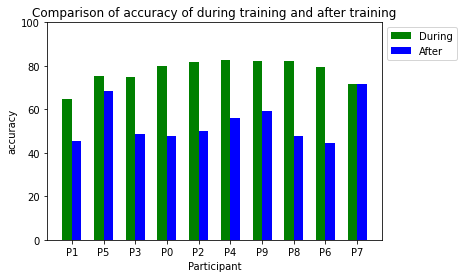

In [12]:
for _ in tqdm(range(args.randomorder_rounds)):
    Upload_list = random.sample(Participant_keys, args.num_participants)
    During_train = []
    After_train = []

    for key in Upload_list:
        print('='*10, key, '='*10)
        vertical_train(TrainData_dict[key], Participant_dict[key], Server, epochs =  1)
        print(f'Participant {key} testing:')
        accuracy = vertical_testing(Participant_dict[key], Server, test_dataset)
        During_train.append(accuracy)

    print('\n======================\n Testing after all participant train')
    for key in Upload_list:
        print(f'Participant {key} testing:')
        accuracy = vertical_testing(Participant_dict[key], Server, test_dataset)
        After_train.append(accuracy)
    width = 0.3
    x = np.arange(len(Upload_list))
    plt.bar(x,During_train,width, color = 'green', label = "During")
    plt.bar(x+width,After_train,width, color = 'blue', label = "After")
    plt.xticks(x + width/2, Upload_list)
    plt.ylim(0,100)

    plt.title("Comparison of accuracy of during training and after training") # title
    plt.ylabel("accuracy") # y label
    plt.xlabel("Participant") # x label
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.show()

#Vertical training with 2 participant

In [13]:
def vertical_train_2(set1, set2, Client1, Client2, Server, epochs):
  for e in range(epochs):
    epoch_loss_sum = 0
    for i in range(0,len(set1),1):
      it1 = iter(set1)
      it2 = iter(set2)
      (data_1, label_1) = next(it1)
      (data_2, label_2) = next(it2)
      data_1, label_1 = data_1.to(device), label_1.to(device)
      data_2, label_2 = data_2.to(device), label_2.to(device)
      batch_size = data_1.shape[0]
      data_1 = data_1.view(batch_size,-1)
      data_2 = data_2.view(batch_size,-1)
      #print(data_1.shape,data_2.shape,label_1.shape)
      #forward training
      client_out_1 = Client1.LocalTrain(data_1)
      client_out_2 = Client2.LocalTrain(data_2)
      c_out = torch.cat((client_out_1,client_out_2),-1)
      #print(client_out_1.shape,c_out.shape)
      server_out = Server.ServerTrain(c_out)
      
      #Calculating loss
      server_loss = Server.loss_fn(server_out,label_1)
      client_loss_1 = Server.loss_fn(client_out_1,label_1)
      client_loss_2 = Server.loss_fn(client_out_2,label_2)
      #Server backward
      Server.optimizer.zero_grad()
      server_loss.backward(retain_graph=True)
      Server.optimizer.step()
      #Client backward
      Client1.optimizer.zero_grad()
      client_loss_1.backward(retain_graph=True)
      client_loss_1.retain_grad()
      print(client_loss_1.grad)
      Client1.optimizer.step()

      Client2.optimizer.zero_grad()
      client_loss_2.backward()
      Client2.optimizer.step()


#Vertical testing with 2 participant

In [14]:
def vertical_testing_2(Client1, Client2 ,Server, test_dataset):
    Client1.local_network.eval()
    Client2.local_network.eval()
    Server.global_network.eval()

    correct = 0
    epoch_loss_sum = 0
    Labels = []
    Predicts = []
    testloss_history = []
    accu_history = []

    with torch.no_grad():
      
        for i in range(0,len(test_dataset),1):
            it1 = iter(test_dataset)
            it2 = iter(test_dataset)
            (data_1, label_1) = next(it1)
            (data_2, label_2) = next(it2)
            data_1, label_1 = data_1.to(device), label_1.to(device)
            data_2, label_2 = data_2.to(device), label_2.to(device)
            batch_size = data_1.shape[0]
            data_1 = data_1.view(batch_size,-1)
            data_2 = data_2.view(batch_size,-1)

            #forward training
            client_out_1 = Client1.LocalTrain(data_1)
            client_out_2 = Client2.LocalTrain(data_2)
            c_out = torch.cat((client_out_1,client_out_2),-1)
            server_out = Server.ServerTrain(c_out)
            
            #Calculating loss
            label = torch.cat((label_1,label_2),-1)
            server_loss = Server.loss_fn(server_out,label_1)
            epoch_loss_sum += float(server_loss.item())

            predict = server_out.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += predict.eq(label_1.data.view_as(predict)).sum().item()
            Labels = Labels + label_1.tolist()
            Predicts = Predicts + predict.tolist()

        epoch_loss_sum /= len(test_dataset.dataset)
        accuracy = 100. * correct / len(test_dataset.dataset)
        testloss_history.append(epoch_loss_sum)
        accu_history.append(accuracy / 100)
        f1 = f1_score(Labels, Predicts, average = "macro")
        print(f'Test set: Average loss: {epoch_loss_sum:.4f}, Accuracy: {correct}/{len(test_dataset.dataset)} ({accuracy:.2f}%), F1-score: {f1:.4f}')
    return accuracy

#2 Participant training

In [15]:
#測試準確率的 test dataset (全部10,000的資料)
test_dataset = data.DataLoader(dataset=test_set, batch_size=args.test_batch_size,shuffle=True)

# Dataset and Participant Gernerate
Participant_dict = GenerateParticipant(args.num_participants)
TrainData_dict, TestData_dict = SplitData(train_set, test_set, args.num_participants)

# Participants keys
Participant_keys = list(Participant_dict.keys())

# Paticipants num
client_num = 2
# global server initialization
Server = GlobalServer(client_num)

  0%|          | 0/1 [00:00<?, ?it/s]


training P3 and P1
========== P3  and  P1 ==========
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Participant P3 and P1 testing:
Test set: Average loss: 0.0803, Accuracy: 4336/10000 (43.36%), F1-score: 0.3575

training P8 and P2
========== P8  and  P2 ==========
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
N

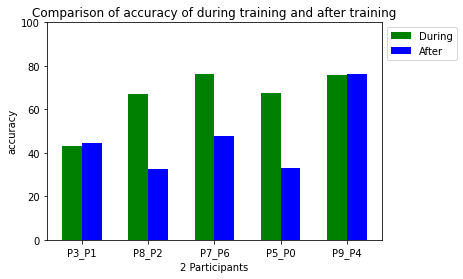

In [16]:
for _ in tqdm(range(args.randomorder_rounds)):
    Upload_list = random.sample(Participant_keys, args.num_participants)
    Client_list = []
    During_train = []
    After_train = []

    for i in range(0,args.num_participants, client_num):
      key1 = Upload_list[i]
      key2 = Upload_list[i+1]
      print(f'\ntraining {key1} and {key2}')
      print('='*10, key1,' and ', key2, '='*10)
      vertical_train_2(TrainData_dict[key1], TrainData_dict[key2], Participant_dict[key1], Participant_dict[key2], Server, 1)
      print(f'Participant {key1} and {key2} testing:')
      accuracy = vertical_testing_2(Participant_dict[key1], Participant_dict[key2], Server, test_dataset)
      dict_key = key1 + "_" + key2
      Client_list.append(dict_key)
      During_train.append(accuracy)

    print('\n===Testing after every train===')
    for i in range(0,args.num_participants, client_num):
      key1 = Upload_list[i]
      key2 = Upload_list[i+1]
      print(f'\nParticipant {key1} and {key2} testing:')
      accuracy = vertical_testing_2(Participant_dict[key1], Participant_dict[key2], Server, test_dataset)
      After_train.append(accuracy)

    width = 0.3
    x = np.arange(len(Client_list))
    plt.bar(x,During_train,width, color = 'green', label = "During")
    plt.bar(x+width,After_train,width, color = 'blue', label = "After")
    plt.xticks(x + width/2, Client_list)
    plt.ylim(0,100)

    plt.title("Comparison of accuracy of during training and after training") # title
    plt.ylabel("accuracy") # y label
    plt.xlabel(str(client_num) + " Participants") # x label
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.show()